# Lab 2 Användning av Keras MLP på MNIST


In [1]:
from PIL import Image, ImageFilter
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import Callback
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm
import numpy as np
import sys
import keras

threads = 12
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': threads}) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.Session(config=config)
keras.backend.set_session(sess)

Using TensorFlow backend.


Två hjälpfunktioner för att visa bilder och lite text på ett rutnät

In [2]:
def formatSquareGrid(grid, trueClass, predictedClass):
    if len(np.shape(trueClass)) == 2: #check if one-hot encoded 2 dim arrays
        trueClass = np.where(trueClass > 0)[1]
    if len(np.shape(predictedClass)) == 2: #check if one-hot encoded 2 dim arrays
        predictedClass = np.where(predictedClass > 0)[1]
    for i in range(len(grid[0])):
        for j in range(len(grid[1])):
            grid[i,j].axis('off')
            grid[i,j].set_title('True: ' + str(trueClass[len(grid[1])*i + j]) + ' Pred: ' + str(predictedClass[len(grid[1])*i + j]))

def drawSquareGrid(grid, displayData):
    cmap = matplotlib.cm.get_cmap('gray') # set to grayscale
    if len(displayData.shape)==2: #Assume square images
        displayData = displayData.reshape(displayData.shape[0], int(np.sqrt(displayData.shape[1])), int(np.sqrt(displayData.shape[1])))
    for i in range(len(grid[0])):
        for j in range(len(grid[1])):
            if np.array(displayData[len(grid[1])*i + j]).max() > 0 :
                scale_factor = 255.0*(1.0/np.array(displayData[len(grid[1])*i + j]).max())
            grayscaleImage = cmap((scale_factor*(np.array(displayData[len(grid[1])*i + j]).max()-np.array(displayData[len(grid[1])*i + j]))).astype(int))
            grid[i,j].imshow(grayscaleImage)

Ladda data från MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Konvertera till one-hot, exempel "5" -> "[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"

In [4]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Visa 3x3 bilder av MNIST

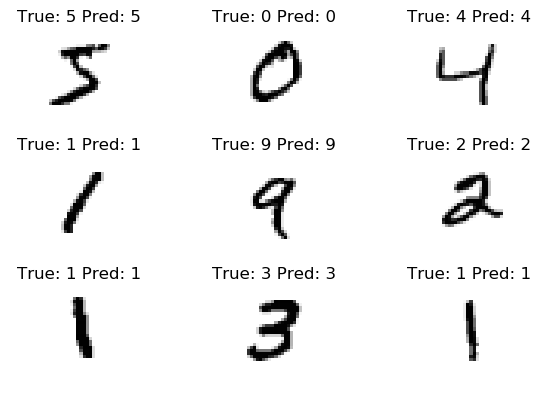

In [5]:
fig, grid = plt.subplots(nrows=3, ncols=3, dpi=100)
fig.tight_layout()
idxs = np.array(range(len(grid[0])*len(grid[1])))

formatSquareGrid(grid = grid, trueClass = y_train[idxs], predictedClass = y_train[idxs])
drawSquareGrid(grid = grid, displayData = x_train[idxs])

Lägg till en sekventiell modell

In [6]:
model = Sequential()

Lägg till ett antal lager

In [7]:
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


En en överskuggad callbackklass för modellanpassningen

In [8]:
class ModelDataCallback(Callback):
    def __init__(self):
        super().__init__
        
    def on_epoch_end(self, batch, logs):
        super().on_epoch_end(batch, logs)
        
    def on_batch_begin(self, batch, logs):
        super().on_batch_begin(batch, logs)
    
    def on_batch_end(self, batch, logs):
        super().on_batch_end(batch, logs)

Några konstanter

In [9]:
batch_size = 256
epochs = 20

Kompilera den sekventiella modellen för en multikategori klassificering

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Anpassa modellen med en callbackinstans

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),callbacks=[ModelDataCallback()])

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[0.08998379643329708, 0.9836]


Prediktera/klassificera på testvektorn

In [13]:
predictions = model.predict(x_test)

Gör en prediktion på den mest sannolika siffran

In [14]:
predictedNumber = np.where(predictions == predictions.max(axis=1)[:,None])[1]
print(predictedNumber)

[7 2 1 ... 4 5 6]


Gör siffran till en one-hot vektor

In [15]:
oneHotPredictedNumber = keras.utils.to_categorical(predictedNumber, 10)
print(oneHotPredictedNumber[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Den sanna siffran

In [16]:
trueNumber = np.where(y_test == y_test.max(axis=1)[:,None])[1]
print(trueNumber)

[7 2 1 ... 4 5 6]


Hitta korrekta klassificeringar

In [17]:
classificationSuccess = np.equal(predictedNumber, trueNumber)
trueNumbers = trueNumber[classificationSuccess]
predictedNumbers = predictedNumber[classificationSuccess]
classifiedImages = x_test[classificationSuccess]

Visa korrekta klassificeringar

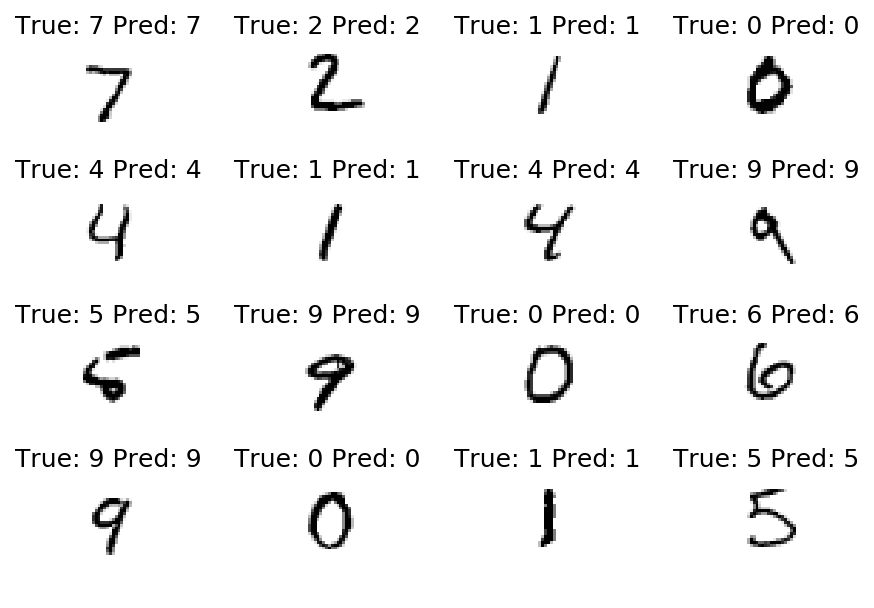

In [18]:
fig2, grid2 = plt.subplots(nrows=4, ncols=4, dpi=150)
fig2.tight_layout()
idxs2 = np.array(range(len(grid2[0])*len(grid2[1])))
formatSquareGrid(grid = grid2, trueClass = trueNumbers[idxs2], predictedClass = predictedNumbers[idxs2])
drawSquareGrid(grid = grid2, displayData = classifiedImages[idxs2])

Hitta felaktiga klassificeringar:

In [19]:
classificationErrors = np.not_equal(predictedNumber, trueNumber)
trueNumbers = trueNumber[classificationErrors]
predictedNumbers = predictedNumber[classificationErrors]
classifiedImages = x_test[classificationErrors]

Visa felaktiga klassificeringar

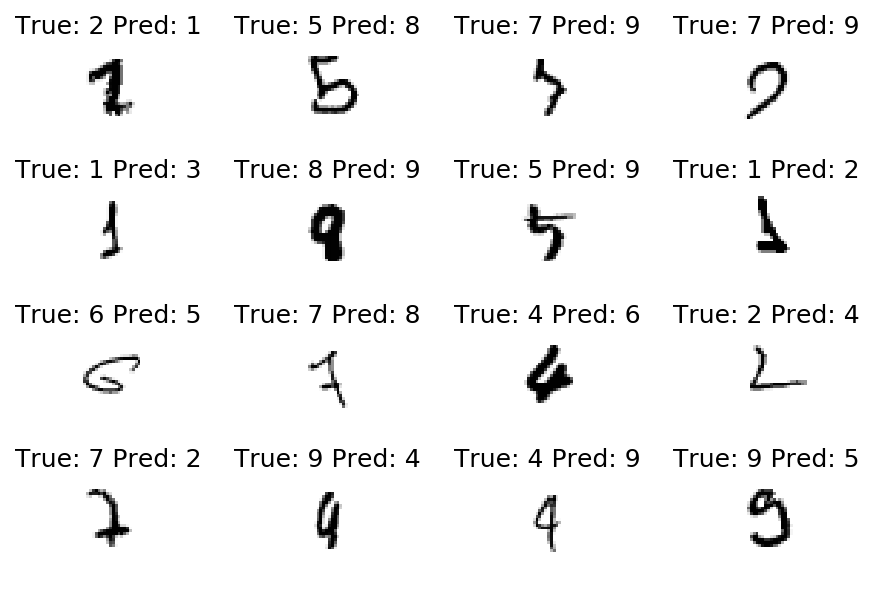

In [20]:
fig3, grid3 = plt.subplots(nrows=4, ncols=4, dpi=150)
fig3.tight_layout()
idxs3 = 10+np.array(range(len(grid2[0])*len(grid2[1])))
formatSquareGrid(grid = grid3, trueClass = trueNumbers[idxs3], predictedClass = predictedNumbers[idxs3])
drawSquareGrid(grid = grid3, displayData = classifiedImages[idxs3])